In [1]:
%matplotlib notebook

from collections import Counter
from itertools import cycle
import json
import os
import pickle
import re
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


from imgaug import augmenters as iaa
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, ResNet50
from keras.applications.vgg16 import VGG16
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from keras.layers import (
    Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, Dense, Dropout)
from keras.models import Model
from keras.optimizers import Nadam
from pycocotools.coco import COCO
from skimage.transform import resize
from sklearn.metrics import precision_recall_curve, average_precision_score
import keras.backend as K
import keras.initializers
import matplotlib.pyplot as plt
import numpy as np
# from herbicide.utils import vis_square

from abyss_deep_learning.keras.classification import (
    ClassificationDataset, caption_map_gen, multihot_gen, augmentation_gen, PRTensorBoard, Inference)
from abyss_deep_learning.keras.utils import (
    batching_gen, lambda_gen, calc_class_weights, count_labels_multi, count_labels_single, gen_dump_data)
import abyss_deep_learning.abyss_dataset as dataset_model

Using TensorFlow backend.


# Configure Data

In [2]:
def instance_to_caption(coco):
    caption_map_r = {cat['id']: cat['name'] for cat in coco['categories']}
    annotations = {}
    for image in coco['images']:
        image_id = image['id']
        anns = [
            annotation for annotation in coco['annotations'] 
            if 'category_id' in annotation and annotation['image_id'] == image_id]
        anns_str = set([caption_map_r[ann['category_id']] for ann in anns]) if anns else {'background'}
        annotations[image_id] = {
          "caption": ','.join(list(anns_str)),
          "id": image_id,
          "image_id": image_id,
          "type": 'class_labels'
        }
    coco['annotations'] = list(annotations.values())
    coco.pop('categories', None)
    coco.pop('captions', None)
    return coco

In [2]:
# working_dir = "/mnt/ssd1/processed/industry-data/project-max/ml/"

In [ ]:
# train_dict = instance_to_caption(json.load(open(working_dir+"training.json","r")))
# with open(working_dir+"train-nb.json","w") as f:
#     json.dump(train_dict,f)

In [ ]:
# val_dict = instance_to_caption(json.load(open(working_dir+"/5-class-val-cf.json","r")))
# with open(working_dir+"val-nb.json","w") as f:
#     json.dump(val_dict,f)

In [7]:
############### CONFIGURE ALL VARIABLES IN THIS CELL ########################
# num_classes assumed from caption_map entries
# image_dims = (224, 224, 3) # Preset for Mobilenet
image_dims = (480, 640, 3) # Preset for InceptionV3
batch_size = 1
NN_DTYPE = np.float32

# maps caption strings to class numbers (ensure minimal set of class numbers)
# eg use {0, 1, 2} not {4, 7, 8}

# Caption type can be either "single" or "multi".
# This sets up various parameters in the system.
# If conversion between single and multi is required this should be done explicitly and presented
# in a separate json file. The internal representation of all the labels is one-hot encoding.
caption_type = "multi" 
caption_map = {
    "IP":0,
    "ED":1,
    "JD":2
}

num_classes = len(caption_map)
caption_map_r = {val: key for key, val in caption_map.items()}

class AbyssCaptionTranslator(ClassificationDataset.AnnotationTranslator):
    '''Translates the CloudFactory labels into a form that works with this script'''
    def filter(self, annotation):
        return 'caption' in annotation and 'type' in annotation and annotation['type'] == 'class_labels'
    def translate(self, annotation):
        return annotation['caption'].split(",")
    

translator = AbyssCaptionTranslator()

working_dir = "/mnt/ssd1/processed/industry-data/project-max/ml/cloud-factory-data/all-classes-no-bg/val-nb.json"
dataset_name = "cf-forward-validation-test"

coco_val = ClassificationDataset(
    caption_map, translator, False,
    working_dir)

val_gen = None

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [8]:
caption_map_r

{0: 'IP', 1: 'ED', 2: 'JD'}

In [9]:
print("val", set([tuple(coco_val.load_caption(image['id'])) for image in coco_val.imgs.values()]))

val {('C',), ('IP', 'ED'), ('JD', 'X'), ('JD', 'IP', 'ED'), ('IP', 'X'), ('X', 'ED'), ('JD', 'IP', 'X', 'ED'), ('JD',), ('RI', 'IP', 'X', 'ED'), ('IP',), ('RI', 'X'), ('X',), ('ED',), ('IP', 'X', 'ED')}


In [10]:
def balanced_val_set(coco):
    captions = [caption 
            for ann in coco.anns.values() if 'caption' in ann
           for caption in ann['caption'].split(',') if caption != "background"]
    smallest_caption, smallest_caption_value = min(Counter(captions).items(), key=lambda x: x[1])
    
    unique_captions = np.unique(captions)
#     print("unique_captions", unique_captions)
    # Count how many images are in each label
    images_in_caption = {
        caption: [ann['image_id'] for ann in coco.anns.values() if caption in ann['caption'].split(',')]
        for caption in unique_captions}
    
    for images in images_in_caption.values():
        np.random.shuffle(images)
    
    # Count how many captions are in each image
    captions_in_image = {
        image_id: ([
            caption
            for ann in coco.anns.values() if ann['image_id'] == image_id and 'caption' in ann
            for caption in ann['caption'].split(',') if caption != "background"])
        for image_id in coco.imgs}
    print("captions_in_image")
    print([len(captions) for image_id, captions in captions_in_image.items()])
    
#     print("smallest", smallest_caption, smallest_caption_value)
    balanced = []
    out = {caption: [] for caption in unique_captions}
    
    def add_to_counts(image_id):
        # Increment counts for all captions in image
        for caption in captions_in_image[image_id]:
            out[caption].append(image_id)
        # Remove image_id from all images_in_caption
        for images in images_in_caption.values():
            if image_id in images:
                images.pop(images.index(image_id))
    
    while any([len(out[caption]) < smallest_caption_value for caption in unique_captions]):
        least = min(out.items(), key=lambda x: len(x[1]))
        image_id = images_in_caption[least[0]].pop()
        add_to_counts(image_id)
        
    out = [j
           for i in out.values()
          for j in i]
    return set(out)


balanced_image_ids_val = balanced_val_set(coco_val)
print("balanced val set size", len(balanced_image_ids_val))

captions_in_image
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [11]:
def preprocess(image, caption):
    image = resize(image, image_dims, preserve_range=True)
    return preprocess_input(image.astype(NN_DTYPE), mode='tf'), caption

def postprocess(image):
    return ((image + 1) * 127.5).astype(np.uint8)
     
def pipeline(gen, aug_config=None):
    return (
        augmentation_gen(
            multihot_gen(
                lambda_gen(
                    caption_map_gen(gen, caption_map, background='background', skip_bg=False)
                , func=preprocess)
            , num_classes=num_classes)
        , aug_config, enable=(aug_config is not None))
    )


aug_config = {
    'flip_lr_percentage': 0.5,
    'flip_ud_percentage': 0.,
    'affine': {
        "order": 1,
        'scale': {
            "x": (0.8, 1.2),
            "y": (0.8, 1.2)
        },
        "rotate": (-10, 10),
        "shear": (-5, 5),
        "mode": 'constant'
    },
#     'color': {
#         'probability': 1.00,
#         'hue': (0, 0),
#         'saturation': (0, 0),
#         'value': (0, 0)
#     }
}
# aug_config = None # Uncomment to remove augmentation (goes around 50% faster but much worse results)

# Evaluate Val Data

- - - Row 1 - - - 
(480, 640, 3) [0 0 0] (-1.0, 1.0)
(480, 640, 3) [0 0 1] (-1.0, 1.0)


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(480, 640, 3) [0 0 0] (-1.0, 1.0)
(480, 640, 3) [1 1 1] (-1.0, 1.0)
(480, 640, 3) [1 1 0] (-1.0, 1.0)
- - - Row 2 - - - 
(480, 640, 3) [1 1 0] (-1.0, 1.0)
(480, 640, 3) [0 0 0] (-1.0, 1.0)
(480, 640, 3) [0 0 0] (-1.0, 1.0)
(480, 640, 3) [1 0 0] (-1.0, 1.0)
(480, 640, 3) [0 0 0] (-1.0, 1.0)
- - - Row 3 - - - 
(480, 640, 3) [1 1 1] (-1.0, 1.0)
(480, 640, 3) [0 0 0] (-1.0, 0.9998529)
(480, 640, 3) [0 0 0] (-1.0, 1.0)
(480, 640, 3) [0 0 0] (-1.0, 1.0)
(480, 640, 3) [1 1 0] (-1.0, 1.0)
- - - Row 4 - - - 
(480, 640, 3) [0 0 0] (-1.0, 1.0)
(480, 640, 3) [0 0 0] (-1.0, 1.0)
(480, 640, 3) [0 0 1] (-1.0, 1.0)
(480, 640, 3) [1 1 0] (-1.0, 1.0)
(480, 640, 3) [1 1 0] (-1.0, 1.0)
- - - Row 5 - - - 
(480, 640, 3) [0 0 0] (-1.0, 1.0)
(480, 640, 3) [0 0 0] (-1.0, 1.0)
(480, 640, 3) [0 0 1] (-1.0, 1.0)
(480, 640, 3) [0 0 1] (-1.0, 1.0)
(480, 640, 3) [0 0 0] (-1.0, 1.0)


<IPython.core.display.Javascript object>


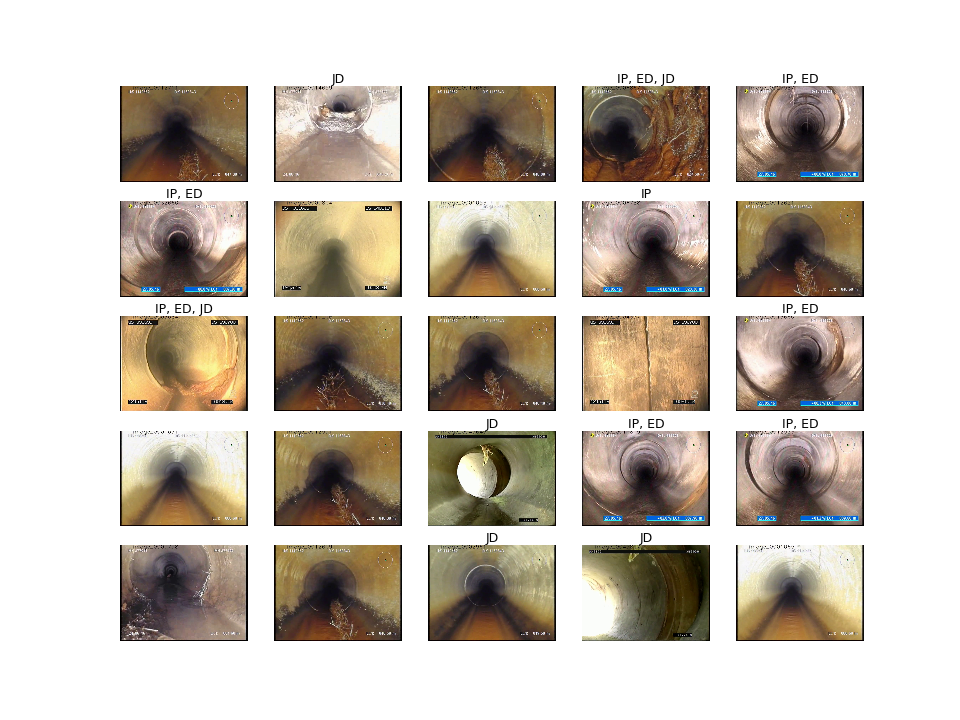

In [12]:
if val_gen is None:
    val_gen = pipeline(coco_val.generator(imgIds=list(balanced_image_ids_val), shuffle_ids=True))

# mpl.rcParams['figure.figsize'] = (10,10)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size']=5

examples= []
width = 5
height = 5
for i in range(height):
    row = []
    print("- - - Row {} - - - ".format(i+1))
    for j in range(width):
        data = next(val_gen)
        row.append(data)
        print(data[0].shape, data[1], (np.min(data[0]), np.max(data[0])))
    examples.append(row)
    
plt.figure()
for i in range(height):
    for j in range(width):
        plt.subplot(height, width, i*width+j+1)
        plt.imshow(postprocess(examples[i][j][0]))
        plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(examples[i][j][1])]), y=0.9)
        plt.axis('off')



# Evaluating Model

In [9]:
# model_instance = "/home/users/jmc/pide/workspace/test-project/models/5-class/5-class-forward/"
model_instance = "/mnt/ssd1/processed/industry-data/project-max/ml/cloud-factory-data/models/"
# model_best_weight = "best.300-0.7164.h5"
# model_initial_learning_rate = 1e-7 ##### IMPORTANT TO SET THIS FROM TENSORBOARD
# num_epoch = 200
class_weights = None # Can't currently resume training with imbalance data #TODO

# model_weights_in_path = os.path.join(search_output_dir, model_instance, "models", model_best_weight)
# log_dir = os.path.join(search_output_dir, model_instance, "continued")
# best_path = os.path.join(log_dir, "models/best.{epoch:03d}-{val_loss:.4f}.h5")
# model_def_path = os.path.join(log_dir, "model_def.json")
# model_info_path = os.path.join(log_dir, "model.json")

K.clear_session()
model = Inference(os.path.join(model_instance, "model.json")).model
model.load_weights(os.path.join(model_instance, "model_weights.h5"))

model.compile( # TODO, load this from JSON, manually change this if you are doing single label
    Nadam(clipnorm=1),
    loss='binary_crossentropy',
    metrics=['binary_accuracy'])

print("Found model with {:d} layers".format(len([1 for layer in model.layers if layer.trainable])))
# print(log_dir)

# callbacks = setup_callbacks(log_dir, hist=None)
# K.set_value(model.optimizer.lr, model_initial_learning_rate)
# history_data[experiment_name] = go(num_epoch, class_weights, initial_epoch=0)
# (Y_true, Y_pred, TP) = evaluate_model(model, test_data, thresh=0.5)
# display_performance(Y_true, Y_pred, TP)

Training: 22 layers


In [10]:
# Specific for the 5->3 example
def pool_preds(Y_pred, max_pool = True):
    Y_pred_pooled = []
    for i in range(len(Y_pred)):
        orig = Y_pred[i]
        
        if max_pool:
            out_pool = np.asarray([max(orig[0],orig[2]), orig[4], max(orig[1],orig[3])])
        else:
            out = [1 if x > 0.5 else 0 for x in orig ]
            out_pool = np.asarray([1 if (out[0] or out[2]) else 0, 1 if (out[4]) else 0, 1 if (out[1] or out[3]) else 0 ])
        Y_pred_pooled.append(out_pool)
    #     print(orig, out, out_pool)

    return np.asarray(Y_pred_pooled)

In [167]:
def evaluate_model_gen(model, val_gen, thresh=0.5, num=100):
    def multi_label_decision(y_true, y_pred):
        return [(y_true > thresh) == (y_pred > thresh)]
    def single_label_decision(y_true, y_pred):
        return np.argmax(y_true, axis=-1) == np.argmax(y_pred, axis=-1)
    decision_function = single_label_decision if caption_type == 'single' else multi_label_decision

    val_data = gen_dump_data(val_gen,num)
    test_data = val_data
    Y_true = test_data[1]
    print(Y_true.shape)
    Y_pred = model.predict(test_data[0])
    print(Y_pred.shape)
    Y_pred = pool_preds(Y_pred)
    print(Y_pred.shape)
    TP = decision_function(Y_true, Y_pred)
#     print(TP[0], np.asarray(TP[0]).shape)
    acc = np.count_nonzero(TP[0]) / TP[0].size
    
    print("Test using {:d} samples:".format(len(test_data[0])))
    print("accuracy", acc)
    return Y_true, Y_pred, TP[0]

In [181]:
def display_performance(Y_true, Y_pred, TP):
    
    plt.rcParams['figure.dpi'] = 100
    
    precision = dict()
    recall = dict()
    thresholds = dict()
    f1 = dict()
    average_precision = dict()
    
    def f1_score(p,r):
        return 2*p*r/(p+r)
    
    for i in range(num_classes):
        precision[i], recall[i], thresholds[i] = precision_recall_curve(Y_true[:, i],
                                                            Y_pred[:, i])
        f1[i] = [f1_score(precision[i][x],recall[i][x]) for x in range(len(precision[i]))]
#         print(i, f1[i])
        average_precision[i] = average_precision_score(Y_true[:, i], Y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_true.ravel(),
        Y_pred.ravel())
    average_precision["micro"] = average_precision_score(Y_true, Y_pred,
                                                         average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))

    z = np.all((Y_pred > 0.5) == Y_true, axis=1)
    acc = np.count_nonzero(z) / z.size
    print("exact accuracy", acc)
    z = ((Y_pred > 0.5) == Y_true)
    acc = np.count_nonzero(z) / z.size
    print("binary accuracy", acc)
    
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plt.figure(figsize=(8, 10))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                  ''.format(average_precision["micro"]))

    text_disp = 0.01
    for i, color in zip(range(num_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        best_f = f1[i].index(max(f1[i]))
#         print(i, best_f, f1[i], max(f1[i]))
        plt.plot(recall[i][best_f],precision[i][best_f],'x',color=color)
        plt.text(recall[i][best_f]+text_disp,precision[i][best_f]+text_disp,'{0:.2f}'.format(thresholds[i][best_f]))
        
        lines.append(l)
        labels.append('{0} (area = {1:0.2f})'
                      ''.format(caption_map_r[i], average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Micro Average Precision vs. Recall')
    plt.legend(lines, labels, loc=(0, -.4), prop=dict(size=14))
    plt.show()
#     plt.savefig(model_plot_path, d

In [178]:
# plt.figure()
# plt.plot(5,5,'x',color='gold')
# plt.text(5.1,5,'hello')
# works 

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(101, 3)
(101, 5)
(101, 3)
Test using 101 samples:
accuracy 0.7194719471947195
Average precision score, micro-averaged over all classes: 0.79
exact accuracy 0.42574257425742573
binary accuracy 0.7194719471947195


<IPython.core.display.Javascript object>


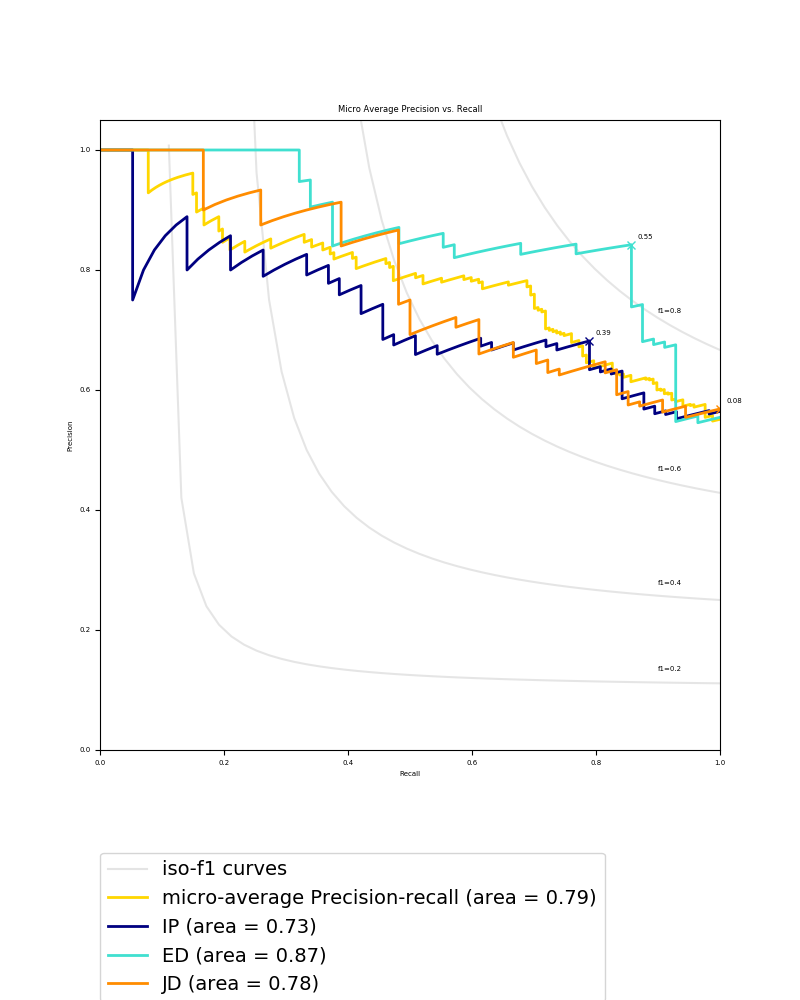

In [182]:
(Y_true, Y_pred, TP) = evaluate_model_gen(model, val_gen, thresh=0.5,num=100)
display_performance(Y_true, Y_pred, TP)

In [166]:
l = [0.713375796178344, 0.7051282051282052, 0.6967741935483871, 0.6883116883116884, 0.6797385620915032, 0.6842105263157894, 0.6887417218543047, 0.6933333333333335, 0.6979865771812079, 0.7027027027027025, 0.6938775510204082, 0.6986301369863013, 0.7034482758620689, 0.7083333333333334, 0.6993006993006994, 0.6901408450704225, 0.6950354609929078, 0.7000000000000001, 0.7050359712230215, 0.7101449275362318, 0.7153284671532847, 0.7058823529411764, 0.7111111111111111, 0.7164179104477612, 0.706766917293233, 0.7121212121212123, 0.7175572519083969, 0.7076923076923075, 0.7131782945736433, 0.7187499999999999, 0.7244094488188976, 0.73015873015873, 0.7200000000000001, 0.7096774193548386, 0.6991869918699187, 0.7049180327868853, 0.7107438016528925, 0.7, 0.6890756302521008, 0.6949152542372881, 0.6837606837606838, 0.6724137931034482, 0.6608695652173914, 0.6666666666666666, 0.6725663716814159, 0.6607142857142857, 0.6666666666666666, 0.6545454545454545, 0.6605504587155964, 0.6481481481481483, 0.6355140186915887, 0.6415094339622641, 0.6285714285714286, 0.6153846153846153, 0.6213592233009708, 0.6274509803921569, 0.6138613861386139, 0.6, 0.6060606060606061, 0.5918367346938775, 0.5773195876288659, 0.5833333333333334, 0.5894736842105263, 0.5744680851063829, 0.5591397849462365, 0.5652173913043479, 0.5714285714285714, 0.5555555555555557, 0.5393258426966292, 0.5454545454545454, 0.528735632183908, 0.5348837209302325, 0.5176470588235293, 0.5, 0.5060240963855422, 0.48780487804878053, 0.4691358024691359, 0.45000000000000007, 0.430379746835443, 0.43589743589743585, 0.41558441558441556, 0.3947368421052632, 0.4, 0.3783783783783784, 0.35616438356164387, 0.3611111111111111, 0.3380281690140845, 0.3142857142857143, 0.2898550724637681, 0.29411764705882354, 0.2686567164179105, 0.24242424242424243, 0.2153846153846154, 0.1875, 0.15873015873015872, 0.12903225806451613, 0.13114754098360656, 0.13333333333333333, 0.10169491525423728, 0.0689655172413793, 0.03508771929824561, 0.0]
len(l)

102

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(25, 3)
(25, 5)
(25, 3)


<IPython.core.display.Javascript object>


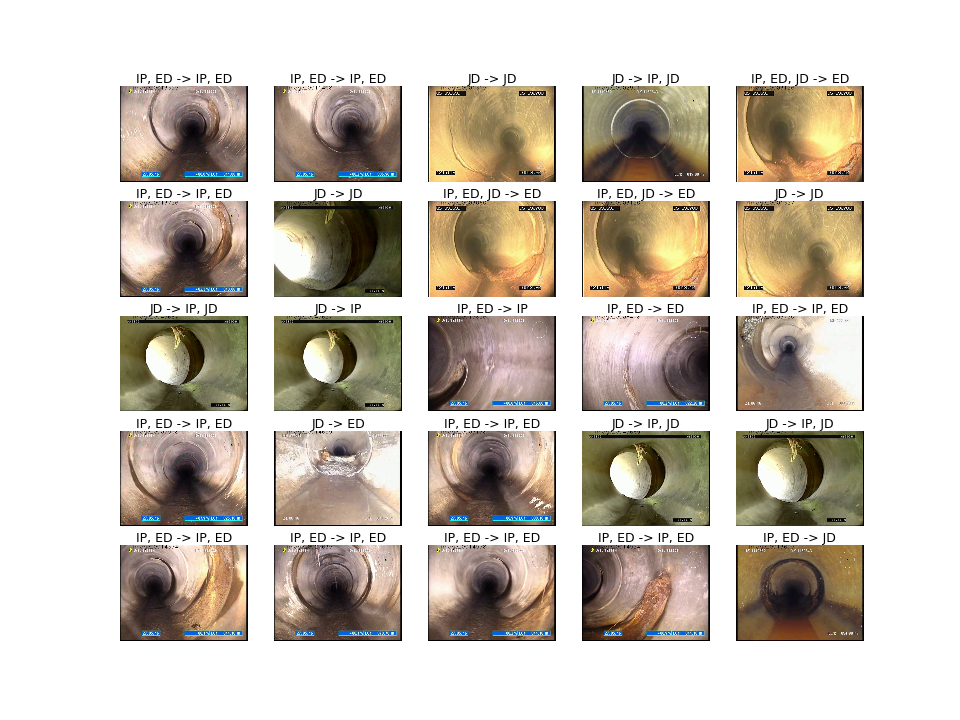

In [15]:
def compare_predictions(val_gen, thresh = 0.5):
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['font.size']=5

    examples= []
    width = 5
    height = 5

    val_data = gen_dump_data(val_gen, width*height-1)
    test_data = val_data
    Y_true = test_data[1]
    images = test_data[0]
    print(Y_true.shape)
    Y_pred = model.predict(test_data[0])
    print(Y_pred.shape)
    Y_pred = pool_preds(Y_pred)
    print(Y_pred.shape)

    plt.figure()
    for i in range(height):
        for j in range(width):

            index = i*width+j
            image = images[index]
            true_caption = Y_true[index]
            pred_caption = Y_pred[index]
            plt.subplot(height, width, index+1)

            plt.imshow(postprocess(image))
            plt.title("{:s} -> {:s}".format(
                ', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(true_caption > thresh)]),
                ', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(pred_caption > thresh)])
                ), y=0.9)
            plt.axis('off')
            
compare_predictions(val_gen)

In [88]:
Y_true = None
Y_pred = None

In [21]:
def basic_stats(val_gen, num, thresh=0.5):
    val_data = gen_dump_data(val_gen,num-1)
    test_data = val_data
    Y_true = test_data[1]
#     images = test_data[0]
    print(Y_true.shape)
    Y_pred = model.predict(test_data[0])
    print(Y_pred.shape)
    Y_pred = pool_preds(Y_pred)
    print(Y_pred.shape)
    
    error_dict = {}
    
    for i,fault in enumerate(caption_map):
        error_dict[fault] = {'TP':0,'TN':0,'FP':0,'FN':0}
        f = error_dict[fault]
        for j in range(num):
            if Y_pred[j,i]>thresh:
                if Y_true[j,i]:
                    f['TP'] += 1
                else:
                    f['FP'] += 1
            else:
                if Y_true[j,i]:
                    f['FN'] += 1
                else:
                    f['TN'] += 1
                    
    
    return error_dict
        
bs = basic_stats(val_gen,1000)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(1000, 3)
(1000, 5)
(1000, 3)


In [23]:
bs

{'ED': {'FN': 142, 'FP': 195, 'TN': 251, 'TP': 412},
 'IP': {'FN': 91, 'FP': 96, 'TN': 350, 'TP': 463},
 'JD': {'FN': 276, 'FP': 29, 'TN': 414, 'TP': 281}}

In [40]:
def print_basic_stats(bs_dict):
    for key in bs_dict:
#         print("___________________________________")
        print("{:<8}| {:<15}".format(key,'Predicted'))
        print("{:<8}| {:<15} {:<10}".format('Truth','T','F'))
        print("________|__________________________")
        print("{:<8}| {:<15} {:<10}".format('T',bs_dict[key]['TP'],bs_dict[key]['FN']))
        print("{:<8}| {:<15} {:<10}\n".format('F',bs_dict[key]['FP'],bs_dict[key]['TN']))
        
    

In [41]:
print_basic_stats(bs)

ED      | Predicted      
Truth   | T               F         
________|__________________________
T       | 412             142       
F       | 195             251       

IP      | Predicted      
Truth   | T               F         
________|__________________________
T       | 463             91        
F       | 96              350       

JD      | Predicted      
Truth   | T               F         
________|__________________________
T       | 281             276       
F       | 29              414       



In [42]:
# plt.figure()
# plt.table()

In [97]:
def FP_stats(val_gen, num, thresh=0.5, gen_new=False,verbose=False):
    if  gen_new or Y_true is None or Y_pred is None:
        val_data = gen_dump_data(val_gen,num-1)
        test_data = val_data
        Y_true = test_data[1]
    #     images = test_data[0]
        print(Y_true.shape)
        Y_pred = model.predict(test_data[0])
        print(Y_pred.shape)
        Y_pred = pool_preds(Y_pred)
        print(Y_pred.shape)
    
    error_dict = {}
    
    for i,_ in enumerate(caption_map):
        fault = caption_map_r[i]
        error_dict[fault] = {}
        f = error_dict[fault]
        for j in range(num):
            if Y_pred[j,i]>thresh and not Y_true[j,i]:
                # Is a False Positive
                if verbose:
                    print(i,fault, Y_pred[j,:],Y_true[j,:],[caption_map_r[int(cap_id)] for cap_id in np.argwhere(Y_true[j,:] > thresh)])
                s = ', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(Y_true[j,:] > thresh)]),
                if s in f:
                    f[s] += 1
                else:
                    f[s] = 1
                    
    
    return error_dict
        
fp = FP_stats(val_gen,100,gen_new=True)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(100, 3)
(100, 5)
(100, 3)
0 IP [0.6729833  0.25996703 0.5955275 ] [0 0 1] ['JD']
0 IP [0.6064306  0.17202981 0.7717923 ] [0 0 1] ['JD']
0 IP [0.5182524 0.0778182 0.9457095] [0 0 1] ['JD']
0 IP [0.7916083  0.41709617 0.5595536 ] [0 0 1] ['JD']
0 IP [0.9075034  0.438232   0.33115909] [0 0 1] ['JD']
0 IP [0.73083144 0.2987147  0.5628182 ] [0 0 1] ['JD']
0 IP [0.78061503 0.2970097  0.63032395] [0 0 1] ['JD']
0 IP [0.53664523 0.14175858 0.7137894 ] [0 0 1] ['JD']
0 IP [0.92672306 0.26499534 0.48979372] [0 0 1] ['JD']
0 IP [0.9510493  0.36381948 0.07004447] [0 0 1] ['JD']
0 IP [0.9393371  0.34265703 0.08159575] [0 0 1] ['JD']
0 IP [0.8262273 0.6070197 0.0853843] [0 1 0] ['ED']
0 IP [0.70394546 0.14476554 0.82472485] [0 0 1] ['JD']
0 IP [0.6898858  0.81332344 0.11289466] [0 1 0] ['ED']
0 IP [0.79825264 0.33212882 0.5402396 ] [0 0 1] ['JD']
0 IP [0.9660396  0.60048026 0.10843907] [0 0 1] ['JD']
0 IP [0.5057844  0.05114854 0.8798395 ] [0 0 1] ['JD']
0 IP [0.53843486 0.07824396 0.6346079 ] [0 0

In [98]:
fp

{'ED': {('JD',): 4},
 'IP': {('ED',): 2, ('JD',): 19},
 'JD': {('IP',): 1, ('IP, ED',): 2}}

In [82]:
def print_F_stats(f_dict,error_type='FN'):
    for key in f_dict:
        sub_keys = f_dict[key].keys()
#         print(sub_keys)
        sub_keys_str = ''.join(['{:<15}'.format(','.join(x)) for x in sub_keys])
#         print(sub_keys_str)
        sub_keys_vals = ''.join(['{:<15}'.format(f_dict[key][x]) for x in sub_keys])
#         print(sub_keys_vals)
        print("{:<8}| {}".format(error_type,sub_keys_str))
#         print("{:<8}| {:<15} {:<10}".format('Truth','T','F'))
        
        print("________|{}".format(''.join(['_______________' for _ in  sub_keys])))
        print("{:<8}| {}".format(key,sub_keys_vals))
        print("\n")
#         print("{:<8}| {:<15} {:<10}\n".format('F',bs_dict[key]['FP'],bs_dict[key]['TN']))
    

In [62]:
fp['ED'][('JD',)]

183

In [108]:
print_F_stats(fp, 'FP')

FP      | JD             
________|_______________
ED      | 4              


FP      | JD             ED             
________|______________________________
IP      | 19             2              


FP      | IP             IP, ED         
________|______________________________
JD      | 1              2              




In [106]:
def FN_stats(val_gen, num, thresh=0.5,gen_new=False,verbose=False):
    if gen_new or Y_true is None or Y_pred is None:
        val_data = gen_dump_data(val_gen,num-1)
        test_data = val_data
        Y_true = test_data[1]
    #     images = test_data[0]
        print(Y_true.shape)
        Y_pred = model.predict(test_data[0])
        print(Y_pred.shape)
        Y_pred = pool_preds(Y_pred)
        print(Y_pred.shape)
    
    error_dict = {}
    
    for i,_ in enumerate(caption_map):
        fault = caption_map_r[i]
        error_dict[fault] = {}
        f = error_dict[fault]
        for j in range(num):
            if Y_pred[j,i]<thresh and Y_true[j,i]:
                # Is a False Positive
                if verbose:
                    print(i,fault, Y_pred[j,:],Y_true[j,:],[caption_map_r[int(cap_id)] for cap_id in np.argwhere(Y_true[j,:] > thresh)])
                s = ', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(Y_true[j,:] > thresh)]),
                if s in f:
                    f[s]+=1
                else:
                    f[s] = 1
                    
    
    return error_dict
        
fn = FN_stats(val_gen,100,gen_new=True,verbose=True)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(100, 3)
(100, 5)
(100, 3)
0 IP [0.4866739  0.85227466 0.27183184] [1 1 0] ['IP', 'ED']
0 IP [0.34580028 0.9491945  0.3125673 ] [1 1 1] ['IP', 'ED', 'JD']
0 IP [0.39072457 0.52236843 0.43055567] [1 1 0] ['IP', 'ED']
0 IP [0.17714027 0.7270861  0.31389958] [1 1 1] ['IP', 'ED', 'JD']
0 IP [0.34763667 0.92035085 0.08976719] [1 1 0] ['IP', 'ED']
0 IP [0.45606005 0.02817476 0.27708465] [1 1 0] ['IP', 'ED']
0 IP [0.21867257 0.96885633 0.19702557] [1 1 1] ['IP', 'ED', 'JD']
0 IP [0.26540536 0.99337834 0.10741898] [1 1 0] ['IP', 'ED']
0 IP [0.11137264 0.82156104 0.24842751] [1 1 1] ['IP', 'ED', 'JD']
0 IP [0.20650764 0.9785775  0.17514011] [1 1 1] ['IP', 'ED', 'JD']
0 IP [0.12907171 0.9357404  0.15759376] [1 1 1] ['IP', 'ED', 'JD']
0 IP [0.4801142  0.5845157  0.10997123] [1 1 0] ['IP', 'ED']
0 IP [0.13761805 0.16445446 0.6009442 ] [1 1 0] ['IP', 'ED']
1 ED [0.91223425 0.2742499  0.10959574] [1 1 1] ['IP', 'ED', 'JD']
1 ED [0.77377176 0.4962459  0.10968182] [1 1 0] ['IP', 'ED']
1 ED [0.8242763 

In [ ]:
def confusion_matrix(val_gen, num, thresh = 0.5):
    val_data = gen_dump_data(val_gen,num-1)
    test_data = val_data
    Y_true = test_data[1]
#     images = test_data[0]
    print(Y_true.shape)
    Y_pred = model.predict(test_data[0])
    print(Y_pred.shape)
    Y_pred = pool_preds(Y_pred)
    print(Y_pred.shape)
    
    error_dict = {}
    label_set = set()
    for j in range(num):
        yp = Y_pred[j,:]
        yt = Y_true[j,:]
        yp_str = ','.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(yp > thresh)])
        yt_str = ','.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(yt > thresh)])
        print(yp,yt)
        print(yp_str,yt_str)
        label_set.add(yp_str)
        label_set.add(yt_str)
        if yp_str in error_dict:
            if yt_str in error_dict[yp_str]:
                error_dict[yp_str][yt_str] += 1
            else:
                error_dict[yp_str][yt_str] = 1
        else:
            error_dict[yp_str] = {yt_str: 1}
     
    
    
#         sub_keys = f_dict[key].keys()
# #         print(sub_keys)
    sub_keys_str = ''.join(['{:<8}'.format(','.join(x)) for x in label_set])
#         print(sub_keys_str)
        
    full_confusion_dict = {}
    for key in label_set:
        full_confusion_dict[key] = {}
        for sub_key in label_set:
            full_confusion_dict[key][sub_key] = 0
            if key in error_dict and sub_key in error_dict[key]:
                full_confusion_dict[key][sub_key] = error_dict[key][sub_key]
            
    
#         print(sub_keys_vals)
    print("{:<8}| {}".format(error_type,sub_keys_str))
    for key in label_set:
        sub_keys_vals = ''.join(['{:<8}'.format(full_confusion_dict[key][x]) for x in label

In [139]:
import pandas as pd

In [145]:
def confusion_matrix(val_gen, num, thresh = 0.5,print_text=False):
    val_data = gen_dump_data(val_gen,num-1)
    test_data = val_data
    Y_true = test_data[1]
#     images = test_data[0]
    print(Y_true.shape)
    Y_pred = model.predict(test_data[0])
    print(Y_pred.shape)
    Y_pred = pool_preds(Y_pred)
    print(Y_pred.shape)
    
    error_dict = {}
    label_set = set()
    for j in range(num):
        yp = Y_pred[j,:]
        yt = Y_true[j,:]
        yp_str = ','.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(yp > thresh)])
        yt_str = ','.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(yt > thresh)])
#         yp_str = yp_str if yp_str != '' else 'none'
#         yt_str = yt_str if yt_str != '' else 'none'
#         print(yp,yt)
#         print(yp_str,yt_str)
        label_set.add(yp_str)
        label_set.add(yt_str)
        if yp_str in error_dict:
            if yt_str in error_dict[yp_str]:
                error_dict[yp_str][yt_str] += 1
            else:
                error_dict[yp_str][yt_str] = 1
        else:
            error_dict[yp_str] = {yt_str: 1}
     
    
    
#         sub_keys = f_dict[key].keys()
# #         print(sub_keys)
    sub_keys_str = ''.join(['{:<15}'.format(x) for x in label_set])
#         print(sub_keys_str)
        
    full_confusion_dict = {}
    for key in label_set:
        full_confusion_dict[key] = {}
        for sub_key in label_set:
            full_confusion_dict[key][sub_key] = 0
            if key in error_dict and sub_key in error_dict[key]:
                full_confusion_dict[key][sub_key] = error_dict[key][sub_key]
            
    
    if print_text:
        print("{:<15}| {}".format('Confuse',sub_keys_str))
        print("_______________|{}".format(''.join(['_______________' for _ in  label_set])))
        for key in label_set:
            sub_keys_vals = ''.join(['{:<15}'.format(full_confusion_dict[key][x]) for x in label_set])
            print("{:<15}| {}".format(key,sub_keys_vals))
        print("\n")
    df = pd.DataFrame.from_dict(full_confusion_dict)            
    return df

{'apple', 'pear'}

In [144]:
confusion_matrix(val_gen, 200)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(200, 3)
(200, 5)
(200, 3)
Confuse        |                IP,ED,JD       ED             IP             ED,JD          JD             IP,ED          IP,JD          
_______________|________________________________________________________________________________________________________________________
               | 0              1              0              0              0              9              2              0              
IP,ED,JD       | 0              0              0              0              0              0              1              0              
ED             | 0              12             2              1              0              15             7              0              
IP             | 0              3              0              2              0              6              5              0              
ED,JD          | 0              0              0              1              0              0              1              0              
JD      

,,ED,"ED,JD",IP,"IP,ED","IP,ED,JD","IP,JD",JD
,0,0,0,0,0,0,0,0
ED,0,2,0,0,2,0,0,1
"ED,JD",0,0,0,0,0,0,0,0
IP,0,1,1,2,1,0,1,0
"IP,ED",2,7,1,5,61,1,0,2
"IP,ED,JD",1,12,0,3,8,0,1,1
"IP,JD",0,0,0,0,0,0,0,0
JD,9,15,0,6,1,0,32,21


Predicted  ED    {'ED': 0, 'IP': 1}
           IP    {'ED': 0, 'IP': 1}
dtype: object

In [107]:
print_F_stats(fn, 'FN')

FN      | IP, ED, JD     IP, ED         
________|______________________________
ED      | 3              9              


FN      | IP, ED, JD     IP, ED         
________|______________________________
IP      | 6              7              


FN      | JD             IP, ED, JD     
________|______________________________
JD      | 15             13             




In [ ]:
if val_gen is None:
    val_gen = pipeline(coco_val.generator(imgIds=list(balanced_image_ids_val), shuffle_ids=True))   

In [ ]:
(Y_true, Y_pred, TP) = evaluate_model_gen(model, val_gen, thresh=0.5)

In [ ]:
display_performance(Y_true, Y_pred, TP)